# Instruction

- Download datasets from links below and run commented code in **Data** section, that will prepare folder with images.
- Fold everything for better understanding

# Links

Texts: [https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset](https://www.kaggle.com/datasets/naderabdalghani/iam-handwritten-forms-dataset)

Words: [https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database](https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database)

# Imports

In [374]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch import tensor
from torch.functional import F
from torchvision import transforms, datasets
from torchvision import models
from torch.utils.data.sampler import WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skimage.morphology import skeletonize
from itertools import product

import pandas as pd
import numpy as np
import os
from PIL import Image
import copy
import cv2
import time
import shutil

from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Params and Helpers

In [375]:
class Params:
    MAX_LEN = 12
    vocab = " abcdefghijklmnopqrstuvwxyz" # 1-indexed
    char_to_index = {char: i for i, char in enumerate(vocab)}
    index_to_char = {i: char for i, char in enumerate(vocab)}

    @staticmethod
    def encode_string(s: str):
        return [Params.char_to_index[char] for char in s]

    @staticmethod
    def decode_string(encoded: list[int]):
        return ''.join([Params.index_to_char[i] for i in encoded if i != 0])

In [376]:
class EarlyStopping:
    def __init__(self, patience=5, save_path='best_model.pth'):
        """
        Args:
            patience (int): How many epochs to wait after the last improvement.
            save_path (str): Path to save the best model.
        """
        self.patience = patience
        self.save_path = save_path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss: float, model: nn.Module):
        """
        Args:
            val_loss (float): Validation loss for the current epoch.
            model (nn.Module): Model to save if it has the best performance so far.
        """
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model: nn.Module):
        """Saves the current best model to the specified path."""
        torch.save(model.state_dict(), self.save_path)

In [377]:
class ProgressBarWithLoss:
    def __init__(self, total_epochs, total_batches):
        self.total_epochs = total_epochs
        self.total_batches = total_batches
        self.bar_length = 30
        self.start_time = time.time()

    def update(self, epoch, batch_idx, train_loss, val_loss=None):
        elapsed_time = time.time() - self.start_time
        progress = (batch_idx + 1) / self.total_batches
        filled_length = int(self.bar_length * progress)
        bar = '=' * filled_length + '-' * (self.bar_length - filled_length)
        print(f"\rEpoch {epoch}/{self.total_epochs} [{bar}] {progress * 100:.2f}%   {elapsed_time:.2f}s   "
              f"Train Loss: {train_loss:.4f}   {f'Val Loss: {val_loss:.4f}\n' if val_loss else ''}", end='')

In [378]:
class Validator:
    def __init__(self, model: nn.Module, val_loader: DataLoader, criterion: nn.Module):
        self.model = model
        self.val_loader = val_loader
        self.criterion = criterion

    def validate(self):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = self.model(images)

                batch_size = images.size(0)
                input_lengths = torch.full(
                    size=(batch_size,), fill_value=outputs.size(0), dtype=torch.long).to(device)
                target_lengths = torch.tensor(
                    [len(seq[seq != 0]) for seq in labels], dtype=torch.long).to(device)

                loss = self.criterion(outputs, labels, input_lengths, target_lengths)
                val_loss += loss.item()

        val_loss /= len(self.val_loader)
        return val_loss

In [379]:
class History:
    def __init__(self):
        self.history = {'train_loss': [], 'val_loss': []}

    def add_epoch(self, train_loss, val_loss):
        """
        Adds the training and validation loss for an epoch.

        Args:
            train_loss (float): Training loss for the epoch.
            val_loss (float): Validation loss for the epoch.
        """
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)

    def plot(self):
        """
        Plots the training and validation loss over epochs.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

# Data

In [381]:
# # Get list of images and labels
# with open('iam_words/words.txt', 'r') as f:
#     words = f.readlines()
# words = [word.strip() for word in words]
# words = words[18:-1]
# words = [w for w in words if ' err ' not in w]
# words = [[w.split(' ')[0], w.split(' ')[-1]] for w in words]
# words = [
#     [f'iam_words/words/{w.split('-')[0]}/{w.split('-')[0]}-{w.split('-')[1]}/{w}.png', y] for w, y in words]
# df = pd.DataFrame(words, columns=['filename', 'word'])
# df = df[df['filename'].apply(os.path.exists)]



# # Filter out invalid images
# valid_rows = []
# for i, (path, label) in df.iterrows():
#     try:
#         with Image.open(path) as img:
#             img.verify()  # Verify that the file is a valid image
#         valid_rows.append((path, label))
#     except Exception as e:
#         print(f"Skipping file {path} due to error: {e}")
#     if i % (len(df) //100 + 1) == 0:
#         print('.', end='')
# print('\n')

# df = pd.DataFrame(valid_rows, columns=df.columns)
# df = df[df['word'].apply(lambda x: all(char in Params.vocab[1:]
#                          for char in x) and len(x) <= Params.MAX_LEN)]



# # Split data into sets convinient for torch dataset
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)
# train_df = train_df.reset_index(drop=True)
# val_df = val_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)



# # Save images in convinient for torch way
# shutil.rmtree('words_data', ignore_errors=True)

# for i, (im, label) in train_df.iterrows():
#     new_path = f'words_data/train/{label.ljust(Params.MAX_LEN, "_")}'
#     if not os.path.exists(new_path):
#         os.makedirs(new_path)
#     im = Image.open(im)
#     im.save(f'{new_path}/{i}.png')
#     if i % (len(train_df) // 100 + 1) == 0:
#         print('.', end='')
# print()

# for i, (im, label) in val_df.iterrows():
#     new_path = f'words_data/val/{label.ljust(Params.MAX_LEN, "_")}'
#     if not os.path.exists(new_path):
#         os.makedirs(new_path)
#     im = Image.open(im)
#     im.save(f'{new_path}/{i}.png')
#     if i % (len(val_df) // 100 + 1) == 0:
#         print('.', end='')
# print()


# for i, (im, label) in test_df.iterrows():
#     new_path = f'words_data/test/{label.ljust(Params.MAX_LEN, "_")}'
#     if not os.path.exists(new_path):
#         os.makedirs(new_path)
#     im = Image.open(im)
#     im.save(f'{new_path}/{i}.png')
#     if i % (len(test_df) // 100 + 1) == 0:
#         print('.', end='')

# Datasets

In [382]:
class HandWritingDataset(datasets.ImageFolder):
    def __init__(
        self,
        root,
        transform: transforms.Compose = None,
        label_transofrm=None,
        augument: transforms.Compose = None
    ):
        self.augument = augument
        if self.augument is not None:
            transform = transforms.Compose([
                augument,
                transform
            ])

        super(HandWritingDataset, self).__init__(root, transform=transform)
        self.classes = [''.join([i if i != '_' else '' for i in word]) for word in self.classes]
        self.label_transform = label_transofrm


    def __getitem__(self, index):
        image, label = super(HandWritingDataset, self).__getitem__(index)
        if self.label_transform is not None:
            label = tensor(self.label_transform(self.classes[label]))

        return image, label

In [383]:
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)  # Stack images into a single tensor
    lengths = torch.tensor([len(label) for label in labels])  # Original lengths of labels
    labels = pad_sequence(labels, batch_first=True, padding_value=0)  # Pad labels
    return images, labels

In [384]:
def create_sampler(dataset: datasets.ImageFolder, epsilon: float=0.004):
    """
    epsilon: how strongly flatten the distribution? 0 means flat, the greater the more similar to original distribution, after 0.01 there is little difference
    """
    df = pd.DataFrame(dataset.samples, columns=['filename', 'class'])
    df['label'] = df['class'].apply(lambda x: ''.join([i for i in dataset.classes[x] if i != ' ']))
    df['length'] = df['label'].apply(len)
    length_df = df['length'].value_counts().sort_index()
    class_count = df['class'].value_counts().sort_index()
    df['class_length'] = df['length'].apply(lambda x: length_df.iloc[x-1])
    df['class_count'] = df['class'].apply(lambda x: class_count.iloc[x])
    df['result'] = 1.0 / df['class_length'] + epsilon
    return WeightedRandomSampler(df['result'].values, len(df['result']))

    # class_counts = np.bincount([label for _, label in dataset.samples])
    # class_weights = 1.0 / class_counts
    # sample_weights = [class_weights[label] for _, label in dataset.samples]
    # return WeightedRandomSampler(sample_weights, len(sample_weights))

### sampler tests

In [385]:
# dist_loader = DataLoader(
#     test_dataset,
#     batch_size=32,
#     num_workers=2,
#     shuffle=True,
#     collate_fn=collate_fn,
# )

# results = []
# for i, (ims, labels) in enumerate(dist_loader):
#     results.extend([Params.decode_string(i) for i in labels.tolist()])

# res_df = pd.DataFrame(results, columns=['word'])

# res_df.value_counts().plot(figsize=(20, 5), logy=True)
# plt.show()

# res_df['word'].apply(len).value_counts().sort_index().plot(ylim=(0, 700))
# plt.show()

In [386]:
# dist_loader = DataLoader(
#     test_dataset,
#     batch_size=32,
#     num_workers=2,
#     sampler=create_sampler(test_dataset, 0),
#     collate_fn=collate_fn,
# )

# repeat = 1
# results = []
# for waiting in range(repeat):
#     for i, (ims, labels) in enumerate(dist_loader):
#         results.extend([Params.decode_string(i) for i in labels.tolist()])

# res_df = pd.DataFrame(results, columns=['word'])

# (res_df.value_counts() / repeat).plot(figsize=(20, 5), logy=True)
# plt.show()

# (res_df['word'].apply(len).value_counts().sort_index() / repeat).plot(ylim=(0, 700))
# plt.show()

# Train test predict

### predict

In [388]:
def predict(model: nn.Module, dataloader: DataLoader, amount: int = 100):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images).squeeze(1)
            labels = labels.squeeze(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend([Params.decode_string(preds.cpu().numpy())])
            all_labels.extend([Params.decode_string(labels.cpu().numpy())])
            if len(all_preds) >= amount:
                break
    return list(zip(all_preds, all_labels))

### train

In [389]:
def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, epochs: int, early_stopping: EarlyStopping, history: History):
    history = History()
    validator = Validator(model, val_loader, criterion)

    for epoch in range(epochs):
        progress_bar = ProgressBarWithLoss(epochs, len(train_loader))
        model.train()
        train_loss = 0.0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            batch_size = images.size(0)
            input_lengths = torch.full(
                size=(batch_size,), fill_value=outputs.size(0), dtype=torch.long).to(device)
            target_lengths = torch.tensor(
                [len(seq[seq != 0]) for seq in labels], dtype=torch.long).to(device)

            loss = criterion(outputs, labels, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            progress_bar.update(epoch + 1, batch_idx, train_loss / (batch_idx + 1))
        
        train_loss /= len(train_loader)
        val_loss = validator.validate()

        progress_bar.update(epoch + 1, len(train_loader) - 1, train_loss, val_loss)

        history.add_epoch(train_loss, val_loss)

        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f"\nEarly stopping at epoch {epoch + 1}")
                break

# Model

In [390]:
class TLModel(nn.Module):
    def __init__(self,):
        super(TLModel, self).__init__()
        self.mnv2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2).features[:-1]
        
        for param in self.mnv2.parameters():
            param.requires_grad = False
            
        self.gru = nn.GRU(input_size=320, hidden_size=64, num_layers=1,
                  batch_first=True, bidirectional=False, dropout=0.5)
        self.dense = nn.Linear(self.gru.hidden_size * (self.gru.bidirectional + 1), 27)

    def forward(self, x):
        x = self.mnv2(x)

        x = x.permute(0, 3, 2, 1)
        x = x.flatten(2)

        x, _ = self.gru(x)

        x = self.dense(x)
        x = x.permute(1, 0, 2)
        x = F.log_softmax(x, dim=2)
        
        return x

# Transform and Loaders

In [ ]:
augument = transforms.Compose([
    transforms.RandomRotation(15, expand=True, fill=(255,)),
    transforms.RandomAffine(0, translate=(0.1, 0.1), fill=(255,)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=(255,)),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

transform = transforms.Compose([
    transforms.Resize((32, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1.0 - x),
    transforms.Normalize((0.5,), (0.5,)),
])

In [391]:
train_dataset = HandWritingDataset(root='words_data/train', transform=transform, label_transofrm=Params.encode_string, augument=augument)
val_dataset = HandWritingDataset(root='words_data/val', transform=transform, label_transofrm=Params.encode_string)
test_dataset = HandWritingDataset(root='words_data/test', transform=transform, label_transofrm=Params.encode_string)

In [392]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, sampler=create_sampler(train_dataset, epsilon=0), collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=True, collate_fn=collate_fn)

# train_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, collate_fn=collate_fn)
# val_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, collate_fn=collate_fn)

# Training

In [393]:
model = TLModel().to(device)
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
early_stopping = EarlyStopping(patience=7)
history = History()

/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [394]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=1, early_stopping=early_stopping, history=history)

Epoch 1/1 [==============================] 100.00%   70.89s   Train Loss: 6.4069   Val Loss: 3.9361


In [395]:
for param in model.mnv2.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
early_stopping = EarlyStopping(patience=7)

In [396]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=1, early_stopping=early_stopping, history=history)

Epoch 1/1 [==============================] 100.00%   66.70s   Train Loss: 3.0540   Val Loss: 3.0276


In [397]:
os.makedirs('models', exist_ok=True)

timestamp = time.strftime("%Y%m%d-%H%M%S")
torch.save(model, f"models/model_{timestamp}.pth")
# model = torch.load(f"models/model_{timestamp}.pth", weights_only=False)
# _ = model.eval()

In [398]:
# model = torch.load(f"models/model_{timestamp}.pth", weights_only=False)
test_loader = DataLoader(test_dataset, batch_size=1,
                         num_workers=2, shuffle=True, collate_fn=collate_fn)
predict(model, test_loader, amount=100)

[('', 'a'),
 ('eeed', 'facilities'),
 ('', 'us'),
 ('atd', 'sentiment'),
 ('d', 'succeeded'),
 ('', 'seen'),
 ('', 'he'),
 ('', 'at'),
 ('', 'be'),
 ('', 'a'),
 ('', 'her'),
 ('', 'are'),
 ('d', 'prepared'),
 ('', 'you'),
 ('', 'of'),
 ('', 'are'),
 ('', 'regular'),
 ('', 'we'),
 ('', 'long'),
 ('', 'in'),
 ('', 'has'),
 ('', 'and'),
 ('', 'of'),
 ('ed', 'pleaded'),
 ('', 'a'),
 ('e', 'bearer'),
 ('', 'for'),
 ('', 'have'),
 ('', 'in'),
 ('d', 'regrettable'),
 ('', 'enigma'),
 ('', 'optimists'),
 ('', 'it'),
 ('', 'the'),
 ('', 'said'),
 ('e', 'character'),
 ('l', 'somewhat'),
 ('', 'in'),
 ('', 'cover'),
 ('', 'the'),
 ('', 'offer'),
 ('', 'on'),
 ('ee', 'enforce'),
 ('', 'and'),
 ('d', 'required'),
 ('', 'in'),
 ('', 'in'),
 ('', 'the'),
 ('s', 'better'),
 ('e', 'before'),
 ('', 'of'),
 ('', 'us'),
 ('', 'than'),
 ('', 'as'),
 ('', 'atomic'),
 ('', 'that'),
 ('', 'goes'),
 ('', 'any'),
 ('', 'while'),
 ('', 'trousers'),
 ('d', 'himself'),
 ('', 'is'),
 ('d', 'canals'),
 ('d', 'prospe

# Visual

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True, collate_fn=collate_fn)
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    if i >= len(images):
        break
    ax.imshow(images[i][0].cpu(), cmap='gray', aspect=8)
    ax.set_title(Params.decode_string(labels[i].tolist()))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [399]:
transform = transforms.Compose([
    # transforms.Resize((32, 512)),
    transforms.ToTensor(),
])

test_dataset = HandWritingDataset(
    root='words_data/test',
    transform=transform,
    label_transofrm=Params.encode_string
)
test_loader = DataLoader(test_dataset, batch_size=1,
                         num_workers=2, shuffle=True)

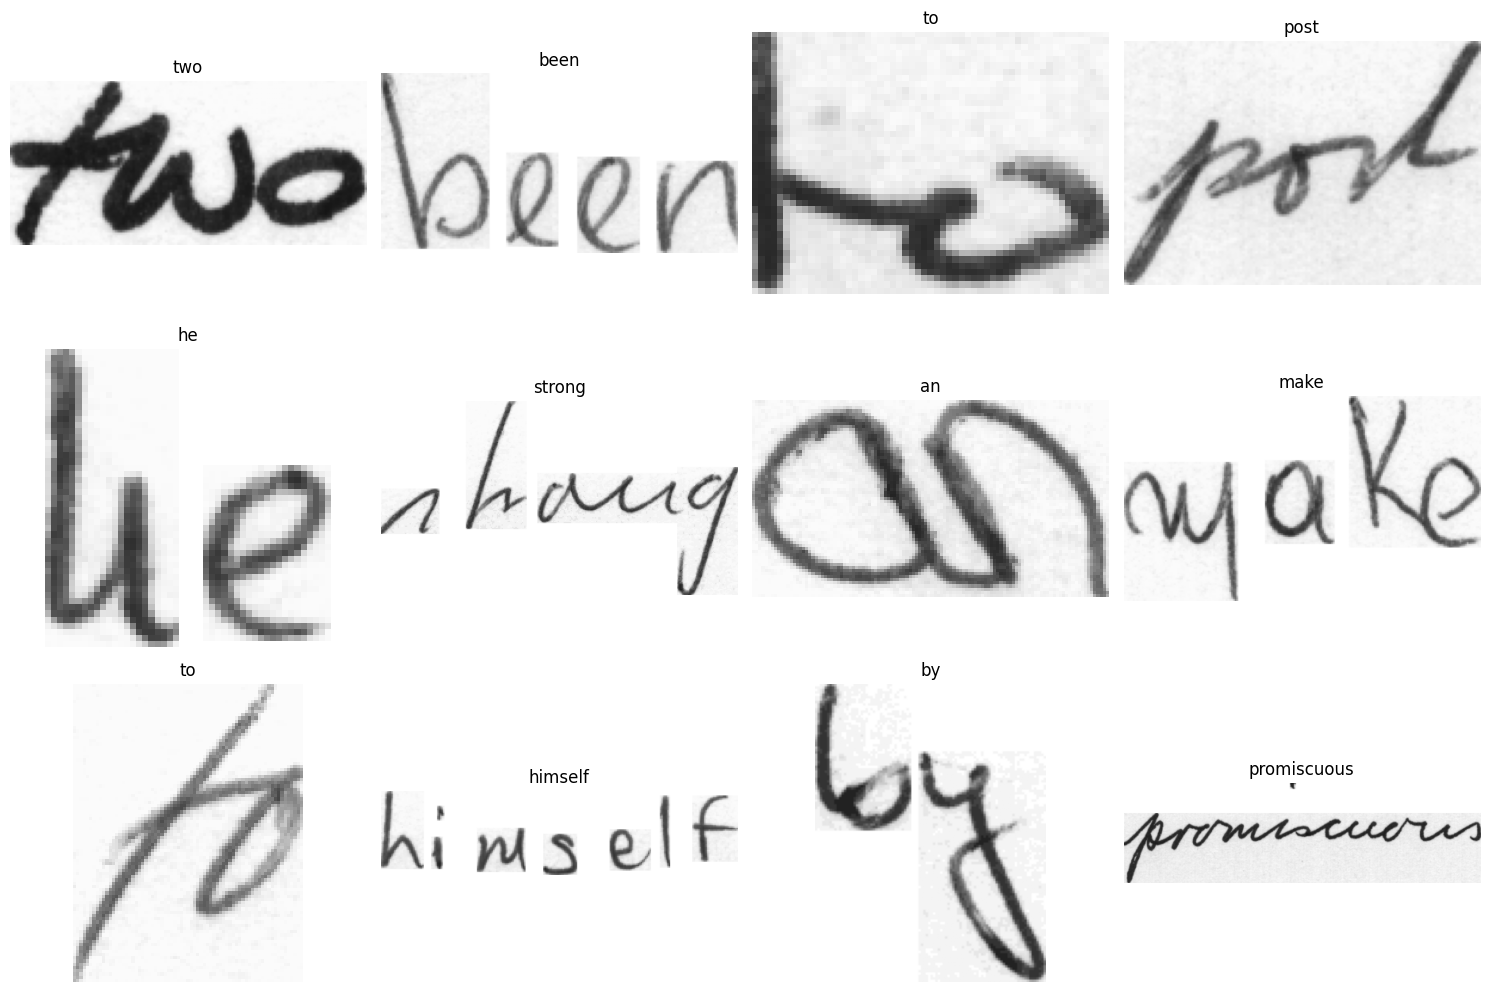

In [400]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, (im, label) in enumerate(test_loader):
    if i >= 12:  # Limit to 12 images for the grid
        break
    toplot = im.squeeze(0).permute(1, 2, 0).cpu().numpy()
    im = im.to(device)
    # res = model(im).squeeze(1).argmax(1).cpu().numpy().tolist()
    label = label.squeeze(0).cpu().numpy().tolist()
    ax = axes[i // 4, i % 4]
    ax.imshow(toplot, cmap='gray', aspect=1)
    ax.set_title(Params.decode_string(label))
    ax.axis('off')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9372549..1.6862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..1.2941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9372549..1.7019608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8901961..1.1843138].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..1.027451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..1.2313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..1.2].
Clipping input d

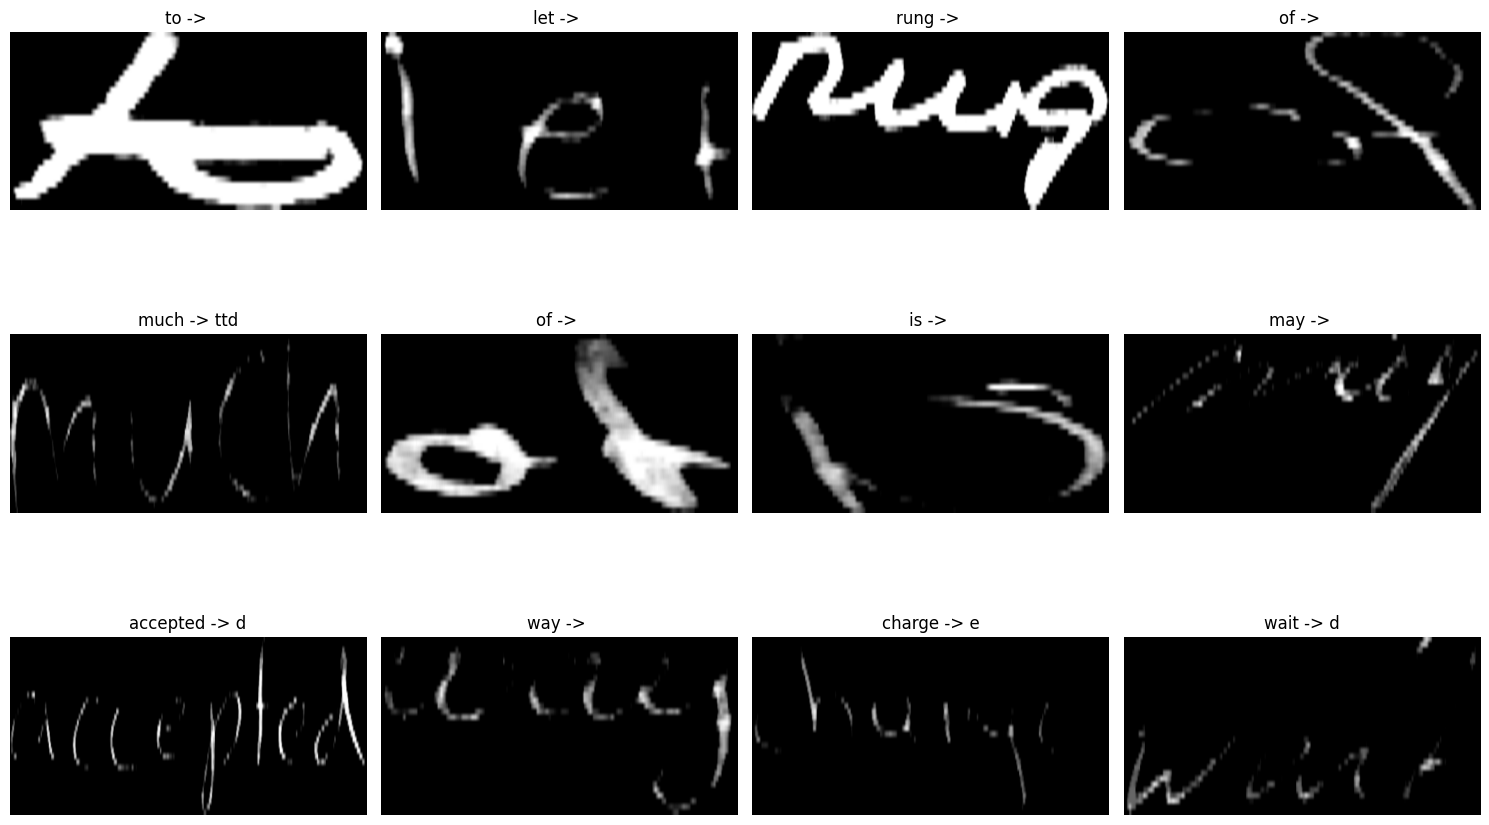

In [401]:
transform = transforms.Compose([
    transforms.Resize((32, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1.0 - x),
    transforms.Normalize((0.5,), (0.5,)),
])

test_dataset = HandWritingDataset(
    root='words_data/test',
    transform=transform,
    label_transofrm=Params.encode_string
)
test_loader = DataLoader(test_dataset, batch_size=1,
                         num_workers=2, shuffle=True)

model = torch.load(f"models/model_{timestamp}.pth", weights_only=False)

with torch.no_grad():
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i, (im, label) in enumerate(test_loader):
        if i >= 12:  # Limit to 12 images for the grid
            break
        toplot = im.squeeze(0).permute(1, 2, 0).cpu().numpy() * 2
        im = im.to(device)
        res = model(im).squeeze(1).argmax(1).cpu().numpy().tolist()
        label = label.squeeze(0).cpu().numpy().tolist()
        ax = axes[i // 4, i % 4]
        ax.imshow(toplot, cmap='gray', aspect=8)
        ax.set_title(Params.decode_string(label) + " -> " + Params.decode_string(res))
        ax.axis('off')
    plt.tight_layout()
    plt.show()